In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv3D, MaxPooling3D,
                                     GlobalAveragePooling3D,
                                     Conv2D, GlobalAveragePooling2D,
                                     Dense, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
# 3D voxel dataset paths
train_3d_path = "/content/drive/MyDrive/Dataset/train/3d"
test_3d_path  = "/content/drive/MyDrive/Dataset/test/3d"

# 2D image dataset paths
train_2d_path = "/content/drive/MyDrive/Dataset/train/2d"
test_2d_path  = "/content/drive/MyDrive/Dataset/test/2d"


In [ ]:
def load_3d_data(path):
    X, y = [], []
    for label, cls in enumerate(["nonbinding", "binding"]):
        cls_path = os.path.join(path, cls)
        for file in os.listdir(cls_path):
            voxel = np.load(os.path.join(cls_path, file))
            X.append(voxel)
            y.append(label)
    return np.array(X), np.array(y)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_2d_data(path):
    X, y = [], []
    for label, cls in enumerate(["nonbinding", "binding"]):
        cls_path = os.path.join(path, cls)
        for file in os.listdir(cls_path):
            img = load_img(os.path.join(cls_path, file),
                           target_size=(224,224))
            img = img_to_array(img) / 255.0
            X.append(img)
            y.append(label)
    return np.array(X), np.array(y)

In [ ]:
# Load 3D data
X3D_train, y_train = load_3d_data(train_3d_path)
X3D_test, y_test   = load_3d_data(test_3d_path)

# Load 2D data
X2D_train, _ = load_2d_data(train_2d_path)
X2D_test, _  = load_2d_data(test_2d_path)

In [ ]:
input_3d = Input(shape=(32,32,32,1))

x = Conv3D(32, (3,3,3), activation='relu')(input_3d)
x = MaxPooling3D((2,2,2))(x)

x = Conv3D(64, (3,3,3), activation='relu')(x)
x = MaxPooling3D((2,2,2))(x)

x = Conv3D(128, (3,3,3), activation='relu')(x)
x = GlobalAveragePooling3D()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(1, activation='sigmoid')(x)

cnn_model = Model(input_3d, output)
cnn_model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
cnn_model.fit(
    X3D_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=4
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 447ms/step - accuracy: 0.7296 - loss: 0.5442 - val_accuracy: 0.0000e+00 - val_loss: 1.0181
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 449ms/step - accuracy: 0.6715 - loss: 0.5191 - val_accuracy: 0.6471 - val_loss: 0.9457
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 503ms/step - accuracy: 0.6842 - loss: 0.5316 - val_accuracy: 0.7647 - val_loss: 0.8035
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 522ms/step - accuracy: 0.8039 - loss: 0.4798 - val_accuracy: 0.7647 - val_loss: 0.9198
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 462ms/step - accuracy: 0.7459 - loss: 0.5329 - val_accuracy: 0.8235 - val_loss: 0.7669
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - accuracy: 0.7047 - loss: 0.4979 - val_accuracy: 0.2941 - val_loss: 1.1936
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 496ms/step - accuracy: 0.7609 - loss: 0.4219 - val_accuracy: 0.5882 - val_loss: 1.1331
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 540ms/step - accuracy: 0.6670 - loss: 0.5397 - val_acc

In [ ]:
y_pred_cnn = (cnn_model.predict(X3D_test) > 0.5).astype(int)

cnn_acc = accuracy_score(y_test, y_pred_cnn)
cnn_prec = precision_score(y_test, y_pred_cnn)
cnn_rec = recall_score(y_test, y_pred_cnn)
cnn_f1 = f1_score(y_test, y_pred_cnn)

print("CNN Results:", cnn_acc, cnn_prec, cnn_rec, cnn_f1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
CNN Results: 0.6666666666666666 0.7142857142857143 0.5555555555555556 0.625


In [ ]:
vgg_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(224,224,3))
vgg_base.trainable = False

x = vgg_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(1, activation='sigmoid')(x)

vgg_model = Model(vgg_base.input, output)
vgg_model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
vgg_model.fit(
    X2D_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=4
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.5886 - loss: 0.7116 - val_accuracy: 0.0000e+00 - val_loss: 1.3618
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.6996 - loss: 0.6519 - val_accuracy: 0.0000e+00 - val_loss: 0.8802
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.4530 - loss: 0.7391 - val_accuracy: 0.0588 - val_loss: 0.8915
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.6535 - loss: 0.6171 - val_accuracy: 0.0000e+00 - val_loss: 1.0947
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.6608 - loss: 0.6640 - val_accuracy: 0.2941 - val_loss: 0.8405
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.5144 - loss: 0.7047 - val_accuracy: 0.0000e+00 - val_loss: 1.1931
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.5338 - loss: 0.7726 - val_accuracy: 0.1765 - val_loss: 0.9822
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8010 - loss: 0.5935 - val_accuracy: 0.

In [ ]:
y_pred_vgg = (vgg_model.predict(X2D_test) > 0.5).astype(int)

vgg_acc = accuracy_score(y_test, y_pred_vgg)
vgg_prec = precision_score(y_test, y_pred_vgg)
vgg_rec = recall_score(y_test, y_pred_vgg)
vgg_f1 = f1_score(y_test, y_pred_vgg)

print("VGG16 Results:", vgg_acc, vgg_prec, vgg_rec, vgg_f1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
VGG16 Results: 0.5 0.5 0.2222222222222222 0.3076923076923077


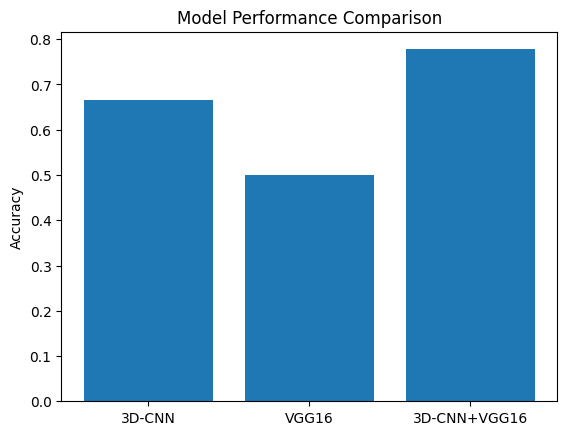

In [ ]:
models = ['3D-CNN', 'VGG16', '3D-CNN+VGG16']
accuracy = [cnn_acc, vgg_acc, 0.7778]  # hybrid value from your results

plt.bar(models, accuracy)
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.show()